In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [18]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

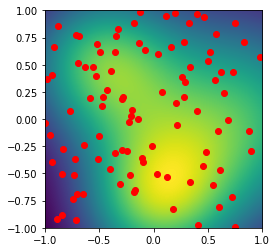

In [19]:
# generate 2d ridge function with random orientation
    
x = np.arange(-1, 1, 0.01)

u = np.random.randn(2, 1)
u = np.array([[1.0],[1.0]])
u = u / np.linalg.norm(u)

f = np.empty(shape=(len(x), len(x)))

for i in range(len(x)):
    for j in range(len(x)):
        
        # ridge function
#         t = x[i]*u[1]+x[j]*u[0]
#         a = -.5
#         f[i][j] = (t-a)*((t-a)>0)-2*((t-a)-.25)*((t-a)>.25)+2*((t-a)-.5)*((t-a)>.5)-2*((t-a)-.75)*((t-a)>.75)

        # smooth function 
        f[i][j] = np.exp(-(x[i])**2 - (x[j]-.75)**2) +np.exp(-2*((x[i]-.5)**2 + (x[j]+.5)**2))+np.exp(-2*((x[i]+.75)**2 + (x[j])**2))

        
plt.imshow(f, extent=[-1,1,-1,1],origin='lower')

# generate samples of 2d function (uniformly at random)
n = 100
V = 2 * np.random.rand(2, n) - 1
#n=10
#V = 2*u*(np.random.rand(1,n)-.5)+.0*np.random.randn(2,n);


plt.scatter(V[0,:],V[1,:], color='r')

# plt.xticks([])
# plt.yticks([])
# plt.savefig("true-smooth.pdf", bbox_inches="tight")

In [20]:
xs = list(zip(V[0,:], V[1,:]))
ys = [0] * len(xs)

In [21]:
for i in range(len(xs)):
    
    # convert to index locations for f array
    idx0 = int((xs[i][0] + 1) * 200 / 2)
    idx1 = int((xs[i][1] + 1) * 200 / 2)
    
#     print(idx0, idx1, i)
    
    ys[i] = f[idx1][idx0] + 0.05 * np.random.randn()

In [22]:
xtrain = torch.tensor(xs).float()
ytrain = torch.tensor(ys).reshape(n, 1).float()

In [23]:
W = 10 * n
model = Net(2, W, 1)

In [24]:
iters = 100001

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

for t in range(iters):
    yhat = model(xtrain)
    
    loss = criterion(yhat, ytrain)

    if t % 10000 == 0:
        print(t, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.35981422662734985
10000 0.0009563631028868258
20000 0.0009645599639043212
30000 0.0009861326543614268
40000 0.0009583932114765048
50000 0.0009508781949989498
60000 0.0009430655627511442
70000 0.0009425081079825759
80000 0.0009601780911907554
90000 0.0009403423755429685
100000 0.001049293321557343


In [25]:
f_out = np.empty(shape=(len(x), len(x)))

for i in range(len(x)):
    for j in range(len(x)):
        
        # convert index to coordinates on [-1, 1] x [-1, 1]
        xout = (i * 2.0) / 200.0 - 1.0
        yout = (j * 2.0) / 200.0 - 1.0
        
        f_out[i][j] = model(torch.tensor([yout, xout]).reshape(1, 2).float())

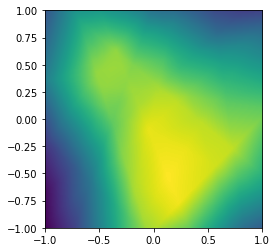

In [26]:
plt.imshow(f_out, extent=[-1,1,-1,1],origin='lower')

# plt.xticks([])
# plt.yticks([])
# plt.savefig("nn-smooth.pdf", bbox_inches="tight")

In [27]:
#from scipy.io import loadmat
#fker=loadmat('kernel.mat')['fhat']
#plt.imshow(np.fliplr(fker))

In [28]:
alpha = 20

K = np.empty(shape=(n,n))

for i in range(n):
    for j in range(n):
        dd = np.linalg.norm(V[:,i]-V[:,j])
        K[i,j] = np.exp(-alpha*dd*dd);

iK = np.linalg.pinv(K)

#a = iK.dot(ys)
a = np.linalg.pinv(K+.01*np.identity(n)).dot(ys)



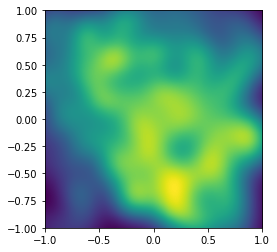

In [29]:

fhat = np.empty(shape=(len(x), len(x)))
z = np.empty(shape=(n,1))

for i in range(len(x)):
    for j in range(len(x)):
        fhat[i,j]=0
        for k in range(n):
            dd = (x[i]-V[0,k])**2+(x[j]-V[1,k])**2
            z[k] = np.exp(-alpha*dd)
            fhat[i,j]=fhat[i,j]+a[k]*z[k]

fhat = np.transpose(fhat)
plt.imshow(fhat, extent=[-1,1,-1,1],origin='lower')

# plt.xticks([])
# plt.yticks([])
# plt.savefig("gaussian-smooth.pdf", bbox_inches="tight")

In [30]:
from scipy.interpolate import RBFInterpolator

In [31]:
xgrid = np.mgrid[-1:1:200j, -1:1:200j]

xflat = xgrid.reshape(2, -1).T

# smoothing is the regularization parameter
yflat = RBFInterpolator(xs, ys, kernel='thin_plate_spline', smoothing=0.01)(xflat)

ygrid = yflat.reshape(200, 200)

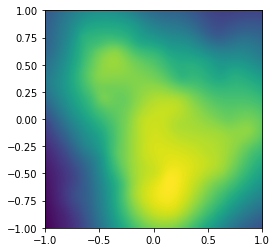

In [32]:
# need to transpose the output so that it's the correct orientation
plt.imshow(ygrid.T, extent=[-1,1,-1,1],origin='lower')

# plt.xticks([])
# plt.yticks([])
# plt.savefig("thin-plate-smooth.pdf", bbox_inches="tight")